In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sudoku-box-detection/aug/_19_5664730.jpeg
/kaggle/input/sudoku-box-detection/aug/_193_6528137.jpeg
/kaggle/input/sudoku-box-detection/aug/_6_1286902.jpeg
/kaggle/input/sudoku-box-detection/aug/_27_9162102.jpeg
/kaggle/input/sudoku-box-detection/aug/_297_9069765.jpeg
/kaggle/input/sudoku-box-detection/aug/_35_1001416.jpeg
/kaggle/input/sudoku-box-detection/aug/_229_1005551.jpeg
/kaggle/input/sudoku-box-detection/aug/_55_8856765.jpeg
/kaggle/input/sudoku-box-detection/aug/_0_3815548.jpeg
/kaggle/input/sudoku-box-detection/aug/_38_4215366.jpeg
/kaggle/input/sudoku-box-detection/aug/_14_8206274.jpeg
/kaggle/input/sudoku-box-detection/aug/_6_2331578.jpeg
/kaggle/input/sudoku-box-detection/aug/_47_4457288.jpeg
/kaggle/input/sudoku-box-detection/aug/_21_5256390.jpeg
/kaggle/input/sudoku-box-detection/aug/_175_838629.jpeg
/kaggle/input/sudoku-box-detection/aug/_10_804061.jpeg
/kaggle/input/sudoku-box-detection/aug/_93_833580.jpeg
/kaggle/input/sudoku-box-detection/aug/_216_289904

---
# SUDOKU PUZZLE

This project aims to solve a Sudoku puzzle from an image of an unsolved puzzle.

## Project Breakdown

### Part One: Digit Classification Model
- Train a neural network on the Chars74K dataset for digit classification.
- Use this model to classify digits in the extracted Sudoku puzzle.

### Part Two: Detecting and Reading the Sudoku from an Image
- Identify the Sudoku puzzle in an image using OpenCV.
- Classify the digits within the detected Sudoku puzzle.
- Extract the puzzle's cell values into an array.

### Part Three: Solving the Puzzle
- Convert the extracted array into a matrix.
- Solve the Sudoku puzzle using recursion.

## Table of Contents

1. [Importing Libraries](#1)
2. [Digit Classification Model](#2)
3. [Loading Data](#3)
4. [Splitting Dataset](#4)
5. [Model Building](#5)
6. [Reading the Sudoku Puzzle](#6)
7. [Detecting Contour](#7)
8. [Splitting Cells and Classifying Digits](#8)
9. [Solving the Sudoku](#9)
10. [End](#10)
---

## <a id="1"></a> Importing Libraries


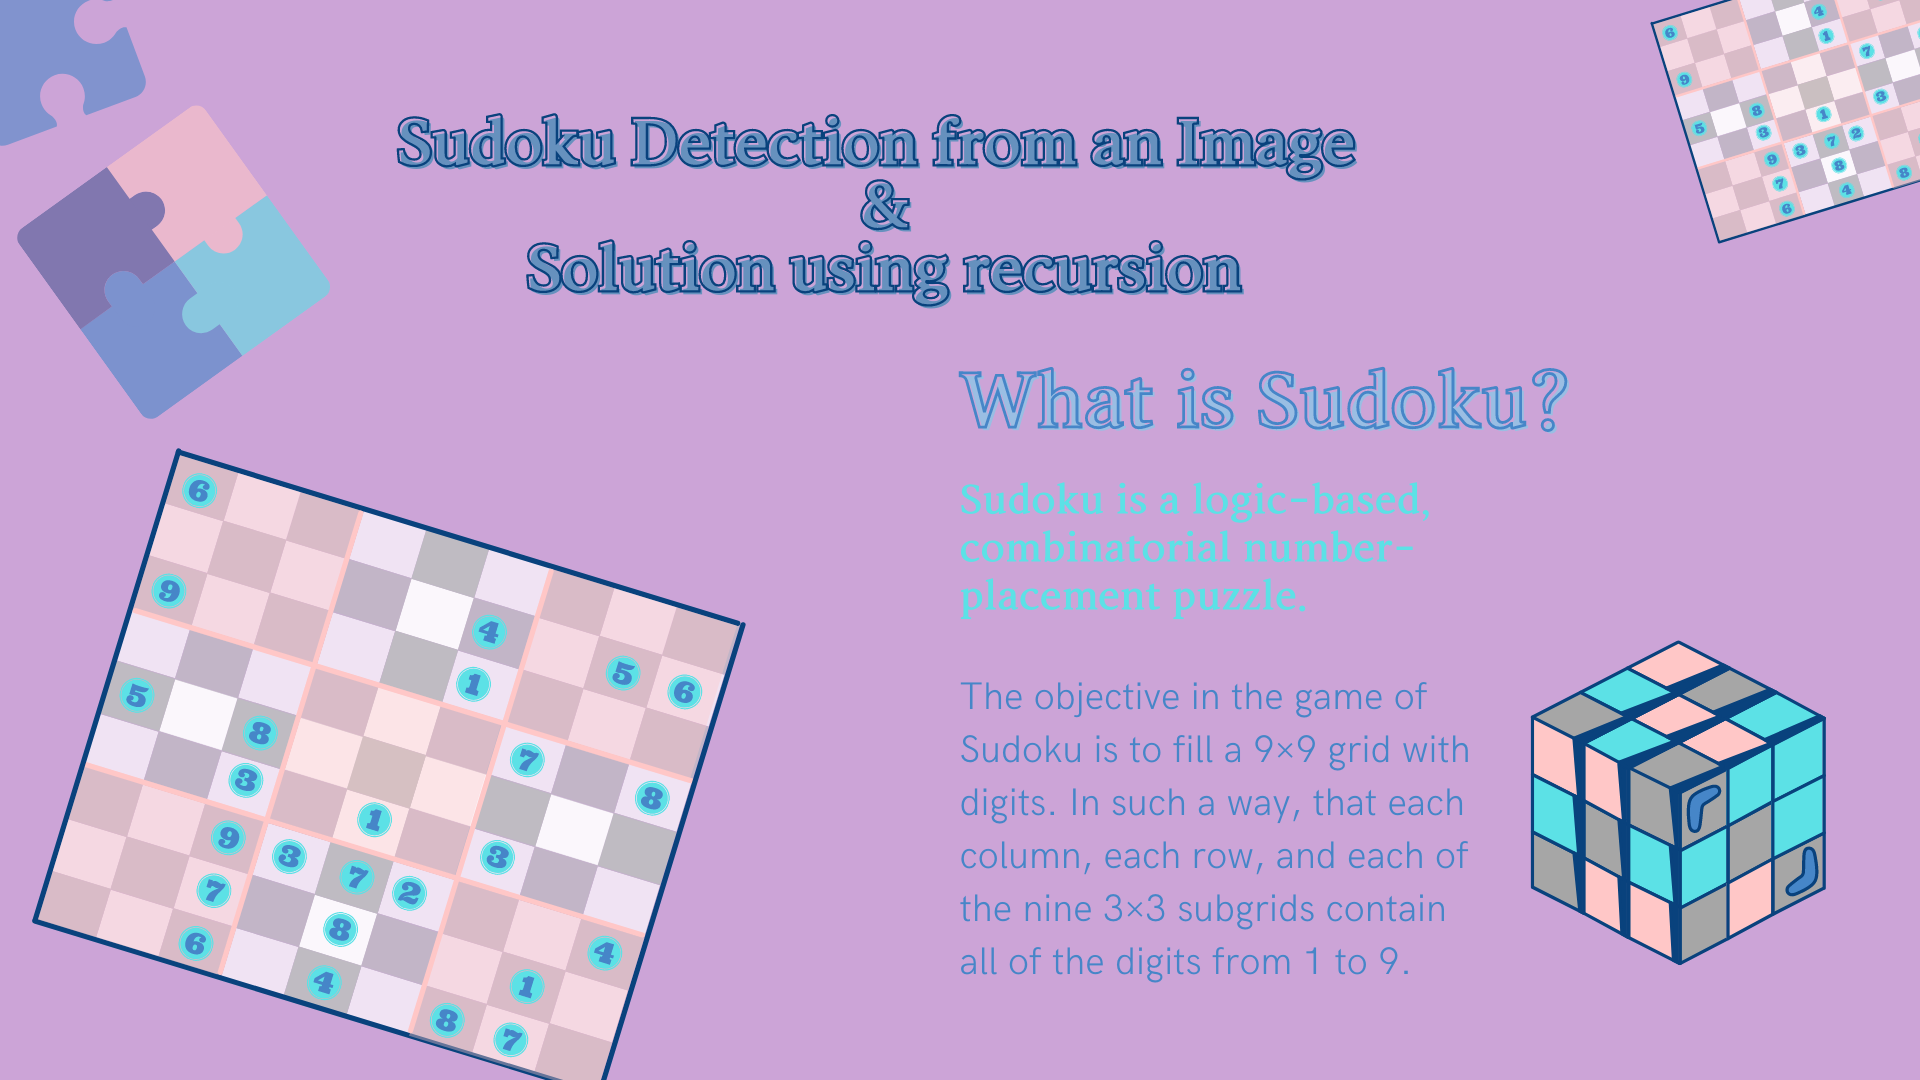

In [17]:
#Loading Libraries

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image 

---
<h1><center>PART ONE</center></h1>

# **Digit Classification Model**  

### **Overview**  
This section covers:  
✅ Loading the dataset  
✅ Splitting into train, test, and validation sets  
✅ Preprocessing the images  
✅ Building and training the classification model  

### **Loading Data**  
The dataset consists of images of digits (0-9).  
- **Features** → Images of handwritten digits  
- **Labels** → Corresponding digit (0-9)  

The data is processed into **NumPy arrays** for model training.
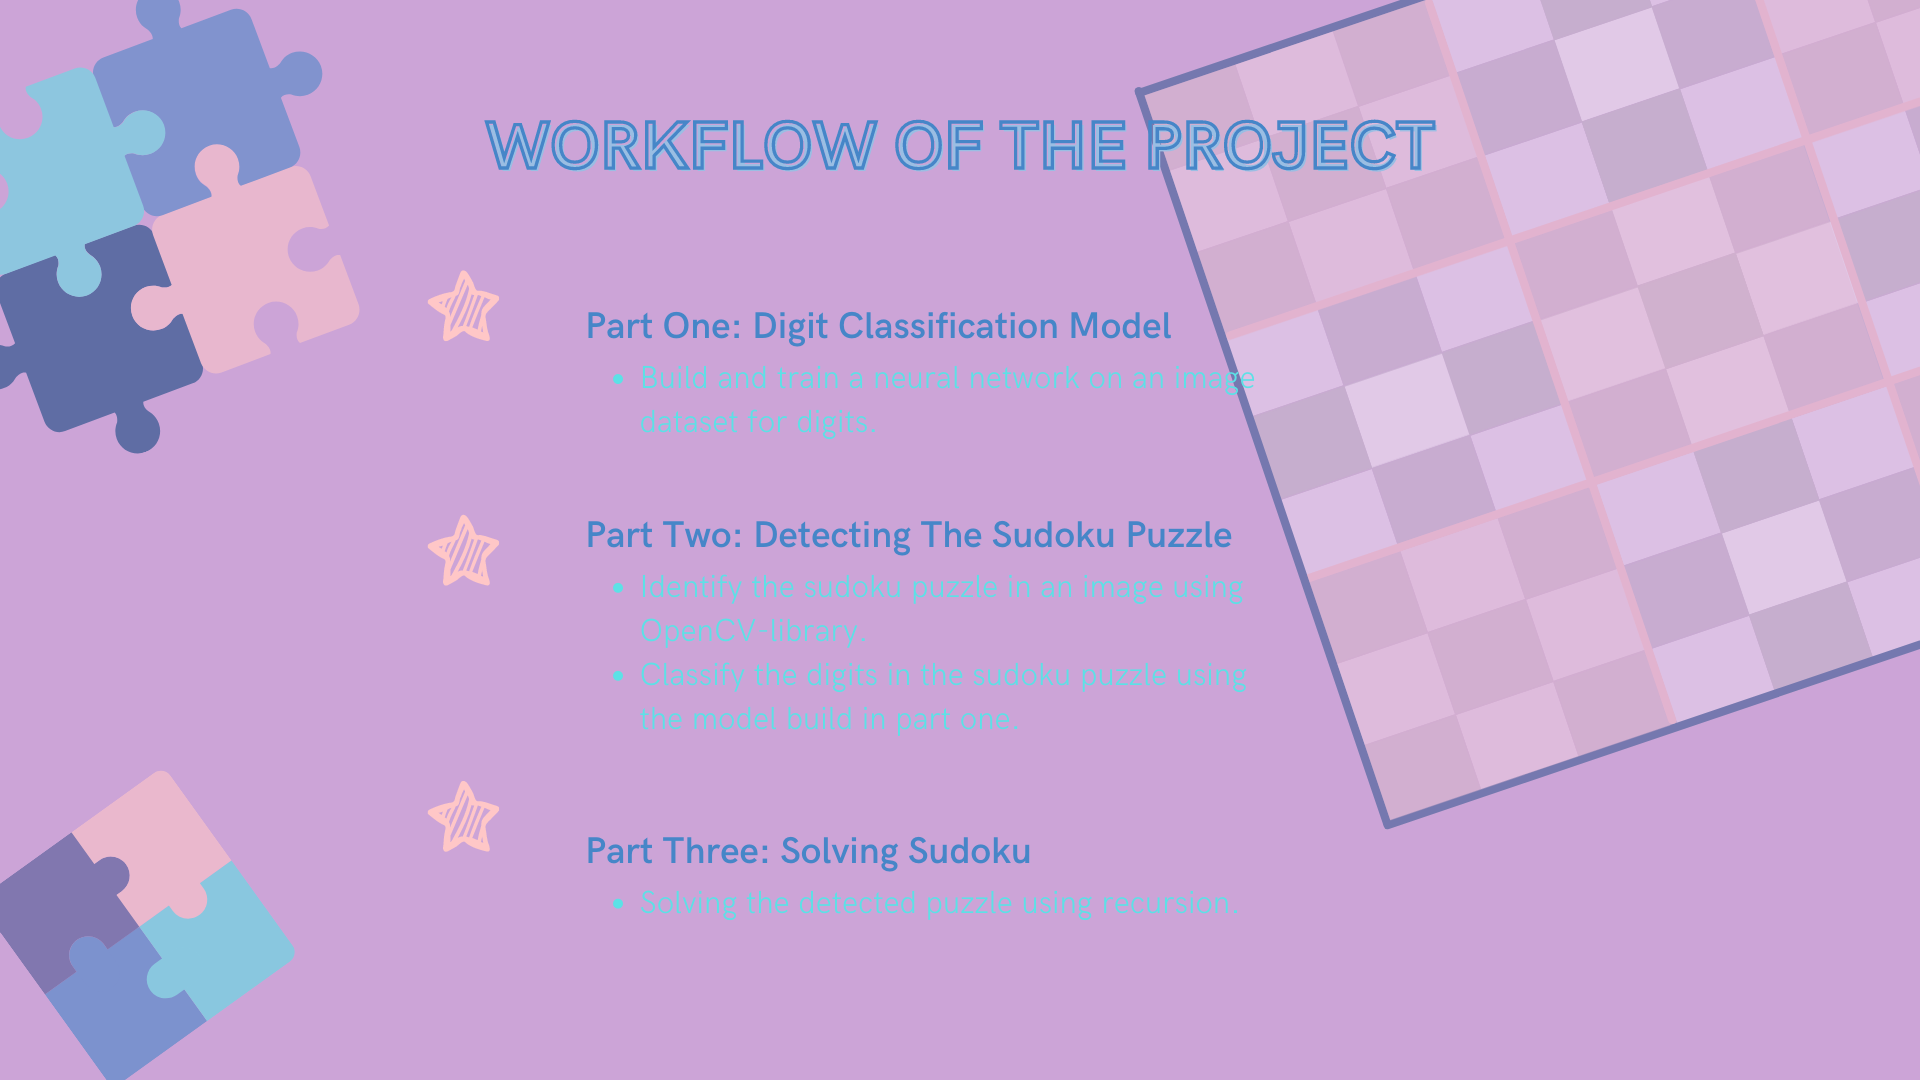

In [18]:
#Loading the data 

data = os.listdir(r"../input/digits/digits updated/digits updated/" )
data_X = []  #
data_y = []  #labels
data_classes = len(data)
for i in range (0,data_classes):
    data_list = os.listdir(r"../input/digits/digits updated/digits updated/" +"/"+str(i))
    for j in data_list:
        pic = cv2.imread(r"../input/digits/digits updated/digits updated/" +"/"+str(i)+"/"+j)
        pic = cv2.resize(pic,(32,32))
        data_X.append(pic)
        data_y.append(i)

         
if len(data_X) == len(data_y) :
    print("Total Dataponits = ",len(data_X))

# Labels and images
data_X = np.array(data_X)
data_y = np.array(data_y)

Total Dataponits =  10160


---
# **SPLITTING DATASET**

Splitting the dataset into test, train and validation sets. Preprocessing for the features (images) into grayscale, enhancing it with histogram equalization and then normalizing. Followed by converting then into a NumPy array. further reshaping the image's array and using data augmentation. Preprocessing for the labels involves one-hot encoding the label classes

In [19]:
#Spliting the train validation and test sets

train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.05)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)
print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (7721, 32, 32, 3)
Validation Set Shape =  (1931, 32, 32, 3)
Test Set Shape =  (508, 32, 32, 3)


In [20]:
# Preprocessing the images for neuralnet

def Prep(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))

#Reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)

#Augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)

datagen.fit(train_X)

In [21]:
# One hot encoding of the labels
train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)



# **MODEL BUILDING**

**For the model, lets build a convolutional neural network.**
* Initialising the Convnet
* Defining by adding layers
* Compiling the Convnet
* Train the Convnet

In [22]:
#Creating a Neural Network

model = Sequential()

model.add((Conv2D(60,(5,5),input_shape=(32, 32, 1) ,padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 30)        8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 30)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 30)         

In [23]:
#Compiling the model

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon = 1e-08, decay=0.0)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

#Fit the model

history = model.fit(datagen.flow(train_X, train_y, batch_size=32),
                              epochs = 30, validation_data = (valid_X, valid_y),
                              verbose = 2, steps_per_epoch= 200)

Epoch 1/30
200/200 - 3s - loss: 0.9216 - accuracy: 0.6873 - val_loss: 0.1095 - val_accuracy: 0.9700
Epoch 2/30
200/200 - 2s - loss: 0.2611 - accuracy: 0.9194 - val_loss: 0.0602 - val_accuracy: 0.9824
Epoch 3/30
200/200 - 2s - loss: 0.1811 - accuracy: 0.9440 - val_loss: 0.0455 - val_accuracy: 0.9860
Epoch 4/30
200/200 - 2s - loss: 0.1349 - accuracy: 0.9570 - val_loss: 0.0492 - val_accuracy: 0.9834
Epoch 5/30
200/200 - 2s - loss: 0.1272 - accuracy: 0.9613 - val_loss: 0.0297 - val_accuracy: 0.9902
Epoch 6/30
200/200 - 2s - loss: 0.1123 - accuracy: 0.9647 - val_loss: 0.0415 - val_accuracy: 0.9876
Epoch 7/30
200/200 - 2s - loss: 0.1027 - accuracy: 0.9683 - val_loss: 0.0310 - val_accuracy: 0.9891
Epoch 8/30
200/200 - 2s - loss: 0.0933 - accuracy: 0.9715 - val_loss: 0.0299 - val_accuracy: 0.9922
Epoch 9/30
200/200 - 2s - loss: 0.0840 - accuracy: 0.9748 - val_loss: 0.0279 - val_accuracy: 0.9938
Epoch 10/30
200/200 - 7s - loss: 0.0960 - accuracy: 0.9707 - val_loss: 0.0309 - val_accuracy: 0.9917

In [24]:
model.save('my_model.h5')

In [25]:
# Load the model
model = load_model('/kaggle/input/sudoku_model/tensorflow2/default/1/my_model.h5')

score = model.evaluate(test_X, test_y, verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.016253823414444923
Test Accuracy = 0.9940944910049438


---
<h1><center>PART TWO</center></h1> 

# **READING THE SUDOKU PUZZLE**

**In this section:**

* Read an image from the dataset 
* Preprocess the image 

_98_1551009.jpeg


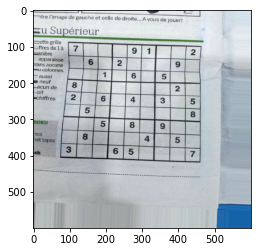

In [26]:
# Randomly select an image from the dataset 

folder=r"../input/sudoku-box-detection/aug"

a=random.choice(os.listdir(folder))
print(a)
sudoku_a = cv2.imread(folder+'/'+a)
plt.figure()
plt.imshow(sudoku_a)
plt.show() 

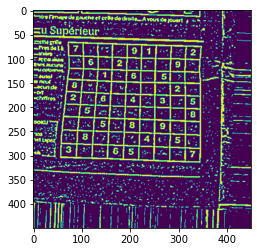

In [27]:
#Preprocessing image to be read
sudoku_a = cv2.resize(sudoku_a, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

#let's look at what we have got
plt.figure()
plt.imshow(threshold)
plt.show()

# **DETECTING CONTOUR**

* Detect the biggest contour of the image.
* Reshaping the outline to get the cropped and well-aligned Sudoku

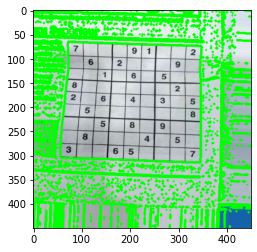

In [28]:
# Finding the outline of the sudoku puzzle in the image
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.show()

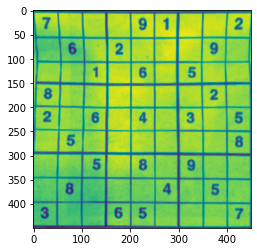

In [29]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(imagewrap)
plt.show()

The goal of [this](https://www.kaggle.com/macfooty/sudoku-box-detection) dataset is to detect the Sudoku box that has been done.  So yey! 

However, some of the images are unfit to use in our model (some are blurr or solved). So to demonstrate solving I have created a toy dataset of one clear picture. I will be using that to run the model and solve the puzzle.

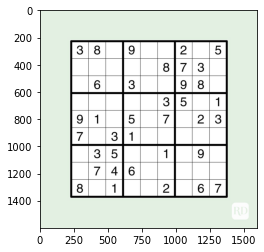

In [32]:
# Importing puzzle to be solved
puzzle = cv2.imread("../input/su-puzzle/su.jpg")

#let's see what we got
plt.figure()
plt.imshow(puzzle)
plt.show()

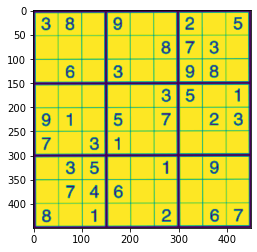

In [33]:
# Resizing puzzle to be solved
puzzle = cv2.resize(puzzle, (450,450))
# Preprocessing Puzzle 
su_puzzle = preprocess(puzzle)

# Finding the outline of the sudoku puzzle in the image
su_contour_1= su_puzzle.copy()
su_contour_2= sudoku_a.copy()
su_contour, hierarchy = cv2.findContours(su_puzzle,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour,-1,(0,255,0),3)

black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
    cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
    su_pts1 = np.float32(su_biggest)
    su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)  
    su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
    su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

# **SPLITTING THE CELLS AND CLASSIFYING DIGITS**

* Splitting the sudoku box into 81 cells with empty spaces or digits 
* Cropping the cells to avoid misdetection of boundary lines as digits
* Using the model to classify the digits in the cells such that the empty cells are classified as zero
* Getting the detected output in the form of an array of 81 digits 

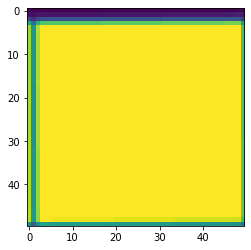

In [34]:
sudoku_cell = splitcells(su_imagewrap)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[58])
plt.show()

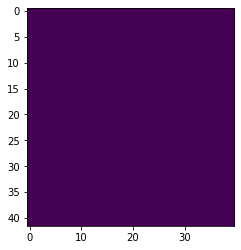

In [35]:
# The sudoku_cell's output includes the boundaries this could lead to misclassifications by the model 
# I am cropping the cells to avoid that
# sneeking in a bit of PIL lib as cv2 was giving some weird error that i couldn't ward off

def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[58])
plt.show()

In [43]:
import numpy as np
import cv2

def read_cells(cell, model):
    result = []
    for image in cell:
        # Preprocess the image
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] - 4]
        img = cv2.resize(img, (32, 32))
        img = img / 255.0
        img = img.reshape(1, 32, 32, 1)
        
        # Getting predictions and setting the values if probabilities are above 65%
        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis=-1)  # Replacing deprecated function
        probabilityValue = np.amax(predictions)
        
        if probabilityValue > 0.65:
            result.append(classIndex[0])
        else:
            result.append(0)
    
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)


---
<h1><center>PART THREE</center></h1> 

# **SOLVING THE SUDOKU**

* Reshaping the array into a 9 x 9 matrix 
* Solving the matrix using recursion

In [44]:
# Reshaping the grid to a 9x9 matrix

grid = np.reshape(grid,(9,9))
grid

array([[3, 8, 0, 9, 0, 0, 2, 0, 5],
       [0, 0, 0, 0, 0, 8, 7, 3, 0],
       [0, 6, 0, 3, 0, 0, 9, 8, 0],
       [0, 0, 0, 0, 0, 3, 5, 0, 1],
       [9, 1, 0, 5, 0, 7, 0, 2, 3],
       [7, 0, 3, 1, 0, 0, 0, 0, 0],
       [0, 3, 5, 0, 0, 1, 0, 9, 0],
       [0, 7, 4, 6, 0, 0, 0, 0, 0],
       [8, 0, 1, 0, 0, 2, 0, 6, 7]])

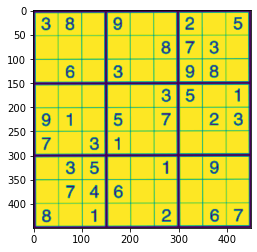

In [45]:
#For compairing 
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

Some numbers may be missing as it may be due to the classification probabilities may be below 65%. It could lead to more than one solution. I am just going with it.

P.S. Adding an arbitrary number could lead to a puzzle with no solution. Whereas, removing numbers increase the combinations.

In [46]:
#This function finds the next box to solve 

def next_box(quiz):
    for row in range(9):
        for col in range(9):
            if quiz[row][col] == 0:
                return (row, col)
    return False

#Function to fill in the possible values by evaluating rows collumns and smaller cells

def possible (quiz,row, col, n):
    #global quiz
    for i in range (0,9):
        if quiz[row][i] == n and row != i:
            return False
    for i in range (0,9):
        if quiz[i][col] == n and col != i:
            return False
        
    row0 = (row)//3
    col0 = (col)//3
    for i in range(row0*3, row0*3 + 3):
        for j in range(col0*3, col0*3 + 3):
            if quiz[i][j]==n and (i,j) != (row, col):
                return False
    return True

#Recursion function to loop over untill a valid answer is found. 

def solve(quiz):
    val = next_box(quiz)
    if val is False:
        return True
    else:
        row, col = val
        for n in range(1,10): #n is the possible solution
            if possible(quiz,row, col, n):
                quiz[row][col]=n
                if solve(quiz):
                    return True 
                else:
                    quiz[row][col]=0
        return 
    
def Solved(quiz):
    for row in range(9):
        if row % 3 == 0 and row != 0:
            print("....................")

        for col in range(9):
            if col % 3 == 0 and col != 0:
                print("|", end=" ")

            if col == 8:
                print(quiz[row][col])
            else:
                print(str(quiz[row][col]) + " ", end="")
                
            

In [47]:
solve(grid)

True

In [48]:
if solve(grid):
    Solved(grid)
else:
    print("Solution don't exist. Model misread digits.")

3 8 7 | 9 4 6 | 2 1 5
5 4 9 | 2 1 8 | 7 3 6
1 6 2 | 3 7 5 | 9 8 4
....................
4 2 6 | 8 9 3 | 5 7 1
9 1 8 | 5 6 7 | 6 2 3
7 5 3 | 1 2 4 | 8 4 9
....................
6 3 5 | 7 8 1 | 4 9 2
2 7 4 | 6 3 9 | 1 5 8
8 9 1 | 4 5 2 | 3 6 7
